# Mouse chimera proof-of-concept

In [1]:
import os,sys
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import scvelo.datasets

import scvi
import torch
device = torch.device("cuda")

sys.path.append('../..')
import q2r_uncertainty.utils
import q2r_uncertainty.q2r_simulation
from q2r_uncertainty.train_models.train_scVI import _train_model,_fit_model

Global seed set to 0


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# ## r2py setup
# import rpy2.rinterface_lib.callbacks
# import logging
# rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# import anndata2ri
# anndata2ri.activate()

# %load_ext rpy2.ipython

## Prepare datasets 

In [ ]:
data_dir = '/nfs/team205/ed6/data/mouse_gastrulation/'
# os.mkdir(data_dir)

In [40]:
!cp /home/jovyan/mount/gdrive/query2reference/processed_data/gastrulation.h5ad /nfs/team205/ed6/data/mouse_gastrulation/

In [48]:
## Full atlas
adata_atlas = scvelo.datasets.gastrulation()

  0%|          | 0.00/4.37G [00:00<?, ?B/s]

In [6]:
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("MouseGastrulationData")

Update all/some/none? [a/s/n]: 

 n


In [9]:
%%R
library(MouseGastrulationData)

In [18]:
%%R
wt_chimera_sce <- WTChimeraData(type = 'processed')
tal1_chimera_sce <- Tal1ChimeraData(type = 'processed')

In [36]:
%%R -o wt_chimera_sce
head(wt_chimera_sce)

class: SingleCellExperiment 
dim: 6 30703 
metadata(0):
assays(1): X
rownames(6): ENSMUSG00000051951 ENSMUSG00000089699 ...
  ENSMUSG00000025902 ENSMUSG00000104328
rowData names(2): ENSEMBL SYMBOL
colnames(30703): cell_1 cell_2 ... cell_30702 cell_30703
colData names(11): cell barcode ... doub.density sizeFactor
reducedDimNames(2): pca.corrected.E7.5 pca.corrected.E8.5
altExpNames(0):


In [35]:
%%R -o tal1_chimera_sce
dim(tal1_chimera_sce)

[1] 29453 56122


In [49]:
adata_atlas.write_h5ad(data_dir + 'MouseGastrulationAtlas.h5ad')
wt_chimera_sce.write_h5ad(data_dir + 'WTChimera.h5ad')
tal1_chimera_sce.write_h5ad(data_dir + 'Tal1Chimera.h5ad')
## Also copied in gdrive /home/jovyan/mount/gdrive/query2reference/ for GPU node

## Load datasets

In [4]:
if os.path.exists('/home/jupyter/'):
    outpath = '/home/jupyter/mount/gdrive/query2reference/mouse_gastrulation/'
elif os.path.exists('/home/jovyan/'):
    outpath = '/home/jovyan/mount/gdrive/query2reference/mouse_gastrulation/'

adata_atlas = sc.read_h5ad(outpath + 'MouseGastrulationAtlas.h5ad')
adata_ctrl = sc.read_h5ad(outpath + 'WTChimera.h5ad')
adata_tal1 = sc.read_h5ad(outpath + 'Tal1Chimera.h5ad')

In [5]:
adata_atlas.var['SYMBOL'] = adata_atlas.var_names.copy()
adata_atlas.var_names = adata_atlas.var['Accession'].values
adata_atlas.var

,Accession,Chromosome,End,Start,Strand,SYMBOL
ENSMUSG00000051951,ENSMUSG00000051951,1,3671498,3205901,-,Xkr4
ENSMUSG00000103377,ENSMUSG00000103377,1,3368549,3365731,-,Gm37180
ENSMUSG00000104017,ENSMUSG00000104017,1,3377788,3375556,-,Gm37363
ENSMUSG00000103025,ENSMUSG00000103025,1,3467285,3464977,-,Gm37686
ENSMUSG00000103201,ENSMUSG00000103201,1,3514507,3512451,-,Gm37329
...,...,...,...,...,...,...
ENSMUSG00000100533,ENSMUSG00000100533,Y,90277501,90275224,+,Gm29504
ENSMUSG00000096178,ENSMUSG00000096178,Y,90433263,90401248,+,Gm20837
ENSMUSG00000095134,ENSMUSG00000095134,Y,90763485,90753057,+,Mid1-ps1
ENSMUSG00000096768,ENSMUSG00000096768,Y,90816464,90784738,+,Gm47283


In [6]:
## Keep common genes
common_vars = np.intersect1d(np.intersect1d(adata_ctrl.var_names, adata_tal1.var_names), adata_atlas.var_names)
adata_atlas = adata_atlas[:,common_vars].copy()
adata_ctrl = adata_ctrl[:,common_vars].copy()
adata_tal1 = adata_tal1[:,common_vars].copy()

In [7]:
## Rename samples to not get scVI confused
adata_atlas.obs['sample'] = "atlas_" + adata_atlas.obs['sample'].astype('str')  
adata_ctrl.obs['sample'] = "WTChimera_" + adata_ctrl.obs['sample'].astype('str')  
adata_tal1.obs['sample'] = "Tal1Chimera_" + adata_tal1.obs['sample'].astype('str')  

## Train models

#### Atlas model

In [8]:
## Feature selection
adata_atlas.layers['counts'] = adata_atlas.X.copy()
if 'log1p' not in adata_atlas.uns.keys():
    sc.pp.normalize_per_cell(adata_atlas)
    sc.pp.log1p(adata_atlas)

sc.pp.highly_variable_genes(
    adata_atlas,
    n_top_genes=5000,
    subset=True
)

hvgs = adata_atlas.var_names.values

In [ ]:
adata_atlas_scvi = adata_atlas[:, hvgs].copy()
scvi.model.SCVI.setup_anndata(adata_atlas_scvi, batch_key="sample", layer='counts')

arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae_ref = scvi.model.SCVI(
    adata_atlas_scvi,
    **arches_params
)

vae_ref.train(early_stopping=True,
              train_size=0.9,
              early_stopping_patience=45,
              max_epochs=200,
              batch_size=1024,
              limit_train_batches=20)
adata_atlas.obsm["X_scVI"] = vae_ref.get_latent_representation()
vae_ref.save(outpath + "MouseGastrulationAtlas_model/", overwrite=True)

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 89267 cells, 5000 vars, 34        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 124/200:  62%|██████▏   | 123/200 [01:44<01:05,  1.18it/s, loss=1.21e+03, v_num=1]

#### Control model

In [ ]:
## Feature selection
adata_ctrl.layers['counts'] = adata_ctrl.X.copy()
if 'log1p' not in adata_ctrl.uns.keys():
    sc.pp.normalize_per_cell(adata_ctrl)
    sc.pp.log1p(adata_ctrl)

In [ ]:
sc.pp.highly_variable_genes(
    adata_ctrl,
    n_top_genes=5000,
    subset=True
)

hvgs = adata_ctrl.var_names.values

In [12]:
adata_ctrl_scvi = adata_ctrl[:, hvgs].copy()
scvi.model.SCVI.setup_anndata(adata_ctrl_scvi, batch_key="sample", layer='counts')

arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae_ref = scvi.model.SCVI(
    adata_ctrl_scvi,
    **arches_params
)

vae_ref.train(early_stopping=True,
              train_size=0.9,
              early_stopping_patience=45,
              max_epochs=200,
              batch_size=1024,
              limit_train_batches=20)
adata_ctrl.obsm["X_scVI"] = vae_ref.get_latent_representation()
vae_ref.save(outpath + "WTChimera_model/", overwrite=True)

Epoch 200/200: 100%|██████████| 200/200 [02:32<00:00,  1.31it/s, loss=1.68e+03, v_num=1]


In [13]:
sc.pp.neighbors(adata_ctrl, use_rep='X_scVI', n_neighbors=30)
sc.tl.umap(adata_ctrl)

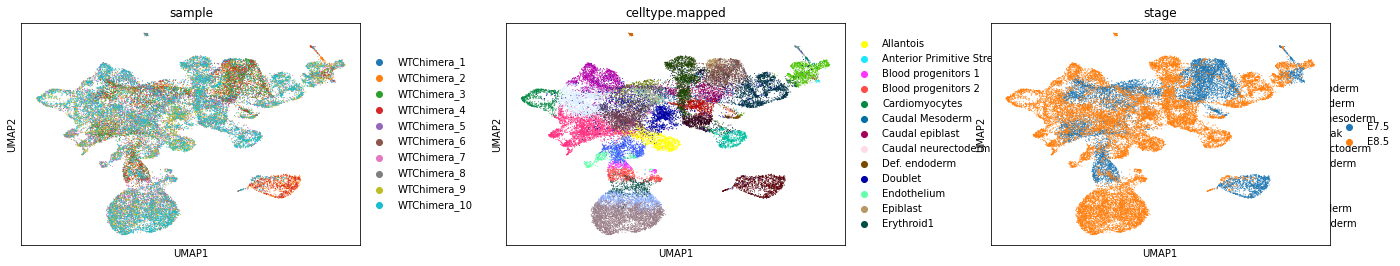

In [14]:
sc.pl.umap(adata_ctrl, color=['sample', 'celltype.mapped', 'stage'], wspace=0.3)

### Fit Tal1-/- to atlas model

In [49]:
vae_atlas = scvi.model.SCVI.load(outpath + "MouseGastrulationAtlas_model/", adata=adata_atlas_scvi)

INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 89267 cells, 5000 vars, 34        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


In [16]:
vae_ctrl = scvi.model.SCVI.load(outpath + "WTChimera_model/", adata=adata_ctrl_scvi) 

INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 30703 cells, 5000 vars, 10        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


In [17]:
adata_tal1.layers['counts'] = adata_tal1.X.copy()

In [18]:
## Map Tal1 to atlas 
vae_tal1_fit_atlas = q2r_uncertainty.train_models.train_scVI._fit_model(adata_tal1, vae_atlas, batch_col='sample')
vae_tal1_fit_atlas.save(outpath + "Tal1Chimera_model_fit_atlas/", overwrite=True)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 56122 cells, 5000 vars, 38        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [11:55<00:00,  3.58s/it, loss=1.39e+03, v_num=1]


In [19]:
## Map Tal1 to ctrl 
vae_tal1_fit_ctrl = q2r_uncertainty.train_models.train_scVI._fit_model(adata_tal1, vae_ctrl, batch_col='sample')
vae_tal1_fit_ctrl.save(outpath + "Tal1Chimera_model_fit_ctrl/", overwrite=True)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 56122 cells, 5000 vars, 14        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [11:45<00:00,  3.53s/it, loss=1.43e+03, v_num=1]


In [50]:
adata_ctrl = sc.read_h5ad(outpath + 'WTChimera.h5ad')
adata_ctrl.obs['sample'] = "WTChimera_" + adata_ctrl.obs['sample'].astype('str')  
adata_ctrl.layers['counts'] = adata_ctrl.X.copy()

In [51]:
## Map ctrl to atlas
vae_ctrl_fit_atlas = q2r_uncertainty.train_models.train_scVI._fit_model(adata_ctrl, vae_atlas, batch_col='sample')
vae_ctrl_fit_atlas.save(outpath + "WTChimera_model_fit_atlas/", overwrite=True)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 30703 cells, 5000 vars, 44        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [06:05<00:00,  1.83s/it, loss=1.7e+03, v_num=1] 


## Co-embeddings 

In [52]:
adata_tal1 = sc.read_h5ad(outpath + 'Tal1Chimera.h5ad')
adata_tal1.obs['sample'] = "Tal1Chimera_" + adata_tal1.obs['sample'].astype('str')  
adata_tal1.layers['counts'] =adata_tal1.X.copy()

In [54]:
vae_tal1_fit_atlas = scvi.model.SCVI.load(outpath + "Tal1Chimera_model_fit_atlas/", adata=adata_tal1[:,adata_atlas_scvi.var_names]) 
vae_tal1_fit_ctrl = scvi.model.SCVI.load(outpath + "Tal1Chimera_model_fit_ctrl/", adata=adata_tal1[:,adata_ctrl_scvi.var_names]) 
vae_ctrl_fit_atlas = scvi.model.SCVI.load(outpath + "WTChimera_model_fit_atlas/", adata=adata_ctrl[:,adata_atlas_scvi.var_names]) 

In [57]:
## perturbation-atlas
pa_design_adata = adata_atlas.concatenate(adata_tal1, batch_key='dataset', batch_categories=['atlas', 'Tal1Chimera'])
# del pa_design_adata.obs['_scvi_labels']
pa_design_adata.obsm["X_scVI"] = vae_tal1_fit_atlas.get_latent_representation(pa_design_adata)

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 145389 cells, 5000 vars, 38       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


In [59]:
## perturbation-ctrl
pc_design_adata = adata_ctrl.concatenate(adata_tal1, batch_key='dataset', batch_categories=['WTChimera', 'Tal1Chimera'])
# del pc_design_adata.obs['_scvi_labels']
pc_design_adata.obsm["X_scVI"] = vae_tal1_fit_ctrl.get_latent_representation(pc_design_adata[:,adata_ctrl_scvi.var_names])

INFO     Received view of anndata, making copy.                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 86825 cells, 5000 vars, 14        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


In [60]:
## perturbation-ctrl-atlas
ac_design_adata = adata_atlas.concatenate(adata_ctrl, batch_key='dataset', batch_categories=['atlas', 'WTChimera'])
# del ac_design_adata.obs['_scvi_labels']
ac_design_adata.obsm["X_scVI"] = vae_ctrl_fit_atlas.get_latent_representation(ac_design_adata[:,adata_atlas_scvi.var_names])
ac_design_adata = ac_design_adata[ac_design_adata.obs['dataset'] == 'WTChimera'].copy()

pac_design_adata = pa_design_adata.concatenate(ac_design_adata)

INFO     Received view of anndata, making copy.                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 119970 cells, 5000 vars, 44       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


In [61]:
for adata in [pa_design_adata, pc_design_adata, pac_design_adata]:
    sc.pp.neighbors(adata, n_neighbors=30, use_rep="X_scVI")
    sc.tl.umap(adata)

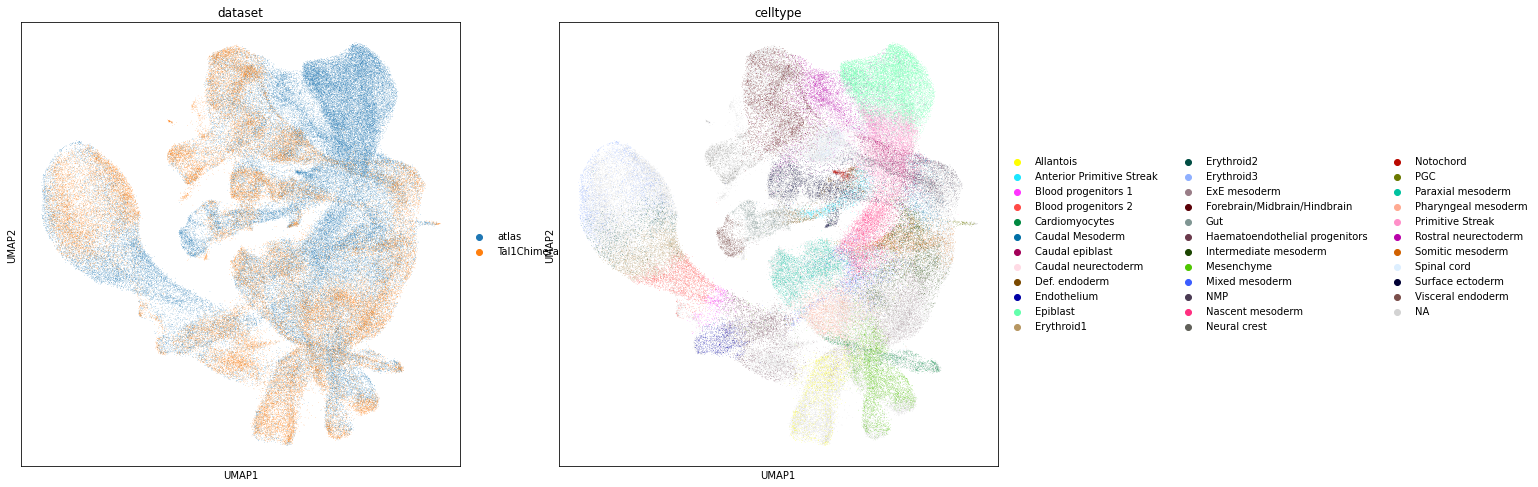

In [64]:
plt.rcParams['figure.figsize'] = [8,8]
sc.pl.umap(pa_design_adata , color=['dataset', 'celltype'])

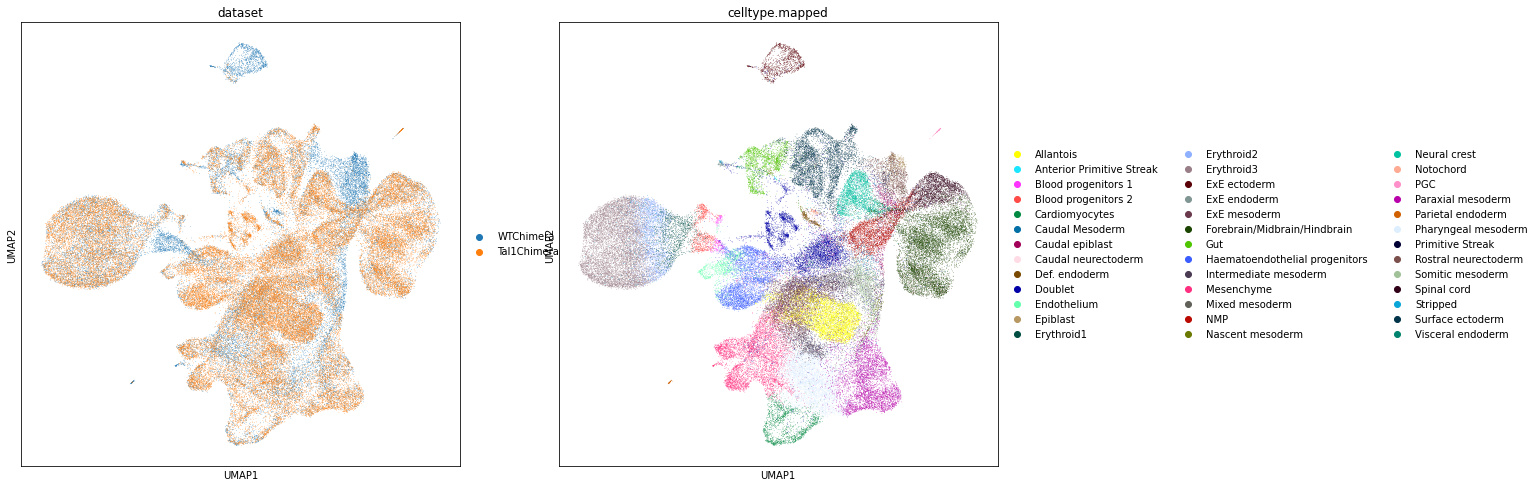

In [68]:
sc.pl.umap(pc_design_adata , color=['dataset', 'celltype.mapped'])

In [63]:
pac_design_adata.obs['chimera_id'] = np.nan
chim_ixs = pac_design_adata.obs['dataset'] != 'atlas'
pac_design_adata.obs.loc[chim_ixs, 'chimera_id'] = pac_design_adata.obs.loc[chim_ixs, 'dataset'].astype('str') + "_tomato" + pac_design_adata.obs.loc[chim_ixs, 'tomato'].astype("str")

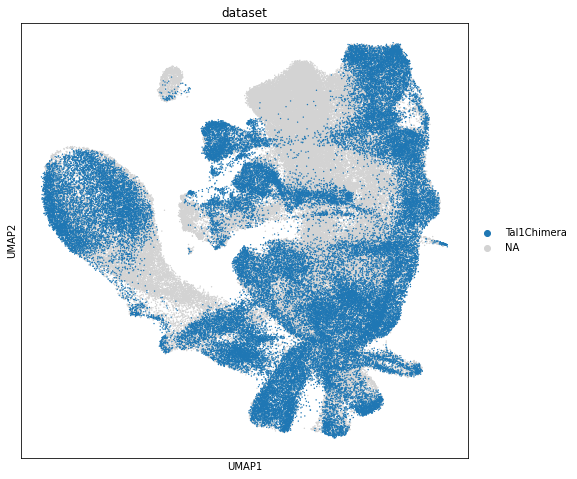

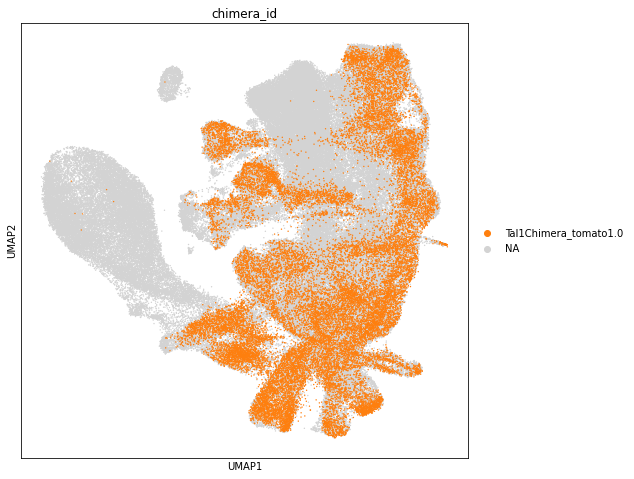

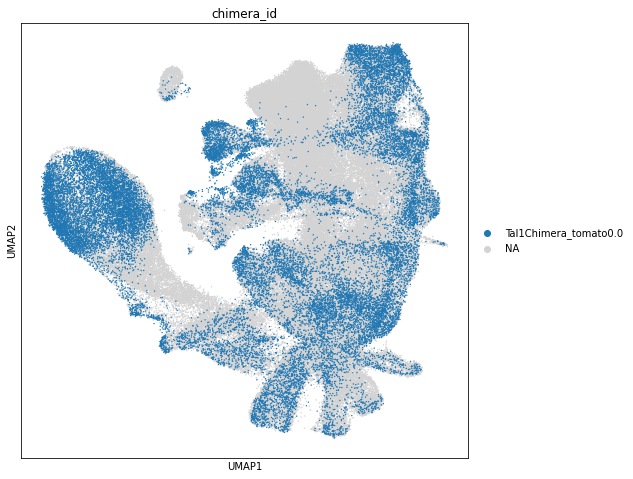

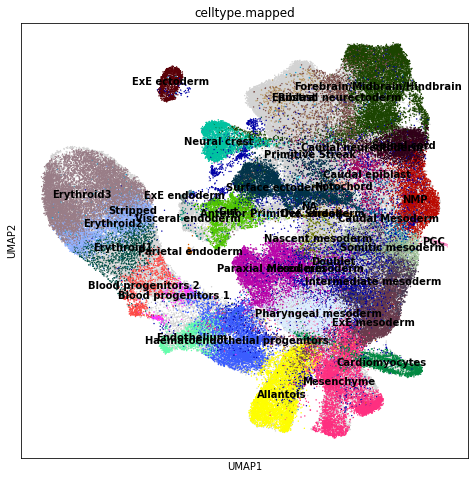

In [69]:
sc.pl.umap(pac_design_adata, color=['dataset'], groups=['Tal1Chimera'], size=8)
sc.pl.umap(pac_design_adata, color=['chimera_id'], size=8, groups=['Tal1Chimera_tomato1.0'])
sc.pl.umap(pac_design_adata, color=['chimera_id'], size=8, groups=['Tal1Chimera_tomato0.0'])
sc.pl.umap(pac_design_adata, color=['celltype.mapped'], legend_loc='on data', size=8)

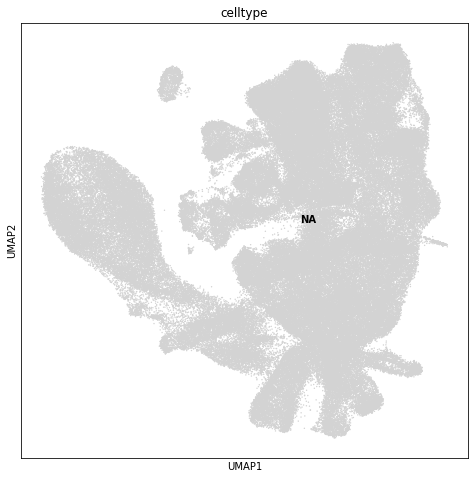

In [70]:
sc.pl.umap(pac_design_adata, color=['celltype'], legend_loc='on data', size=8, groups=['ExE ectoderm'])

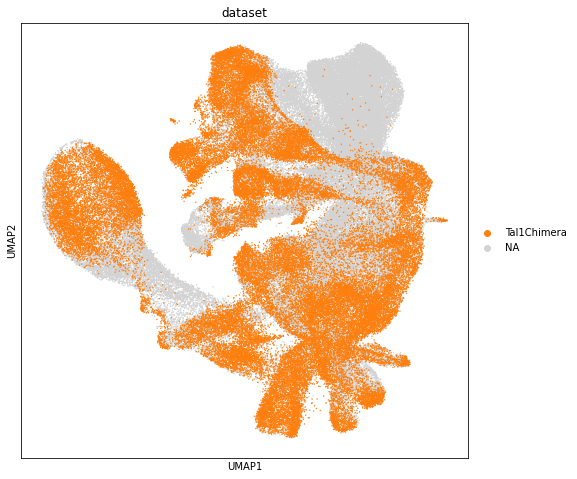

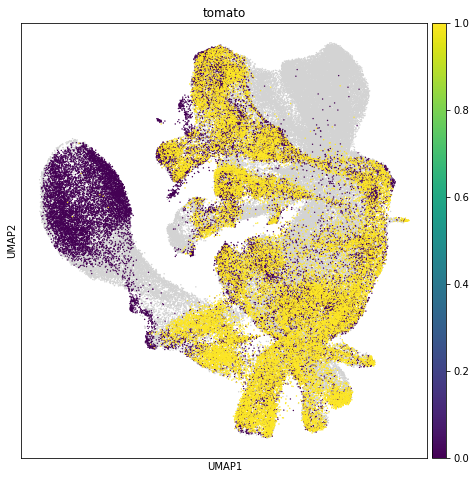

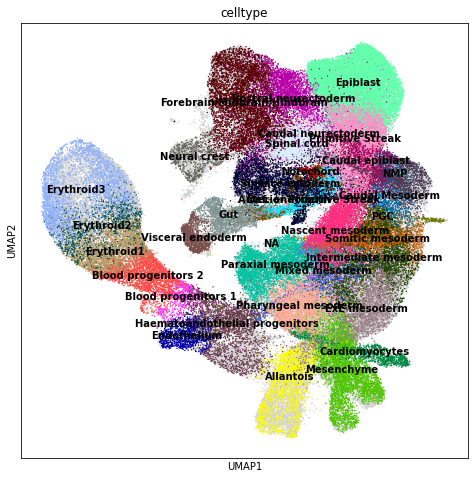

In [66]:
sc.pl.umap(pa_design_adata, color=['dataset'], groups=['Tal1Chimera'], size=8)
sc.pl.umap(pa_design_adata, color=['tomato'], size=8)
sc.pl.umap(pa_design_adata, color=['celltype'], legend_loc='on data', size=8)

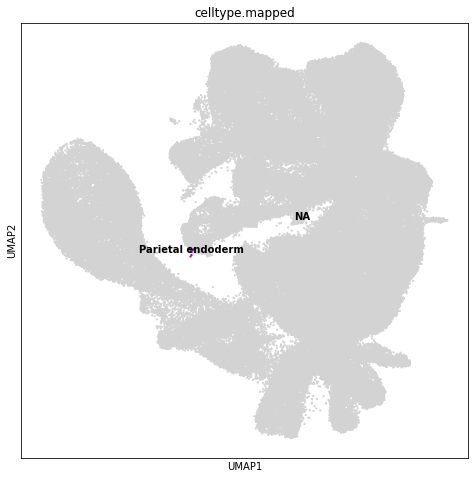

In [77]:
sc.pl.umap(pa_design_adata, color=['celltype.mapped'], legend_loc='on data', groups=['Parietal endoderm'], size=20)

In [121]:
keep_obs = ['barcode', 'sample', 'stage', 'sequencing.batch', 'theiler','celltype',
            'n_counts', '_scvi_batch', '_scvi_labels', 'cell', 'tomato',
       'stage.mapped', 'celltype.mapped', 'batch',
       'dataset'
           ]

In [88]:
pac_design_adata.obs = pac_design_adata.obs[keep_obs]
pa_design_adata.obs = pa_design_adata.obs[keep_obs]
pc_design_adata.obs = pc_design_adata.obs[[x for x in keep_obs if x in pc_design_adata.obs.columns]]

In [ ]:
pa_design_adata.write_h5ad(outpath + "PA_design_coembedding.h5ad")
pac_design_adata.write_h5ad(outpath + "PAC_design_coembedding.h5ad")
pc_design_adata.write_h5ad(outpath + "PC_design_coembedding.h5ad")

## Quantify mapping uncertainty

In [92]:
from q2r_uncertainty.uncertainty_metrics import scArches_uncertainty, KNNconservation, trueVSpred_gex_cosine 
from q2r_uncertainty.predict_gex import generative_posterior_mean

In [95]:
pa_design_adata.obs['dataset'] = ['reference' if x=='atlas' else 'query' for x in pa_design_adata.obs['dataset']] 
pc_design_adata.obs['dataset'] = ['reference' if x=='WTChimera' else 'query' for x in pc_design_adata.obs['dataset']] 
pac_design_adata.obs['dataset'] = ['reference' if x=='atlas' else 'query' for x in pac_design_adata.obs['dataset']] 

In [101]:
pa_design_adata_q = pa_design_adata[pa_design_adata.obs['dataset'] == 'query'].copy()
pac_design_adata_q = pac_design_adata[pac_design_adata.obs['dataset'] == 'query'].copy()
pc_design_adata_q = pc_design_adata[pc_design_adata.obs['dataset'] == 'query'].copy()

In [102]:
pa_design_adata_q.write_h5ad(outpath + "PA_design_query.h5ad")
pac_design_adata_q.write_h5ad(outpath + "PAC_design_query.h5ad")
pc_design_adata_q.write_h5ad(outpath + "PC_design_query.h5ad")

---

In [100]:
## scArches label uncertainty
pa_design_adata.obs['scArches_unc'] = np.nan
pa_design_adata.obs.loc[pa_design_adata.obs.dataset == 'query', 'scArches_unc'] = scArches_uncertainty(merged_adata=pa_design_adata, q2r_emb='X_scVI', anno_col='celltype')
pac_design_adata.obs['scArches_unc'] = np.nan
pac_design_adata.obs.loc[pac_design_adata.obs.dataset == 'query', 'scArches_unc'] = scArches_uncertainty(merged_adata=pac_design_adata, q2r_emb='X_scVI', anno_col='celltype')
pc_design_adata.obs['scArches_unc'] = np.nan
pc_design_adata.obs.loc[pc_design_adata.obs.dataset == 'query', 'scArches_unc'] = scArches_uncertainty(merged_adata=pc_design_adata, q2r_emb='X_scVI', anno_col='celltype.mapped')

In [104]:
pa_design_adata.write_h5ad(outpath + "PA_design_coembedding.h5ad")
pac_design_adata.write_h5ad(outpath + "PAC_design_coembedding.h5ad")
pc_design_adata.write_h5ad(outpath + "PC_design_coembedding.h5ad")

In [103]:
## Distance to posterior uncertainty
generative_posterior_mean(vae_tal1_fit_atlas, pa_design_adata_q)
generative_posterior_mean(vae_tal1_fit_ctrl, pc_design_adata_q)

Global seed set to 42


RuntimeError: [enforce fail at CPUAllocator.cpp:68] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 56122000000 bytes. Error code 12 (Cannot allocate memory)